<a href="https://colab.research.google.com/github/FBallert/vae_fashion_mnist_T3M40508/blob/main/AE_LatentShowcase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation to construct some sample images for a course work paper
Results may differ slightly because of the probabilistic nature of the neural networks and its parameter initialization.

## Basic imports

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random

# Data set loading
Loads the Fashion-MNIST (https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/) dataset. Concatenating train and dev set since we are not interested in any supervised learning tasks an assume this as the available amount of unlabelled data instances.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = np.concatenate((x_train, x_test))
y_train = np.concatenate((y_train, y_test))

4423680/4422102 [==============================] - 0s 0us/step


Add a dimension to the input since images are requested in the shape of (height, widht, channels) for 2D Convolutional Neural Networks (CNN) in Keras.

In [3]:
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

# Classical Autoencoder with convolutional layers

In [4]:
inputs = tf.keras.Input(shape=(28, 28, 1))

# Encoder
x = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x = layers.Flatten()(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
z = tf.keras.layers.Dense(2, activation='relu')(x)

# Create a dedicated encoder model to get the latent representation for the images later
ae_encoder = tf.keras.Model(inputs, z)

# Decoder
x = tf.keras.layers.Dense(16, activation='relu')(z)
x = tf.keras.layers.Dense(14 * 14 * 32, activation='relu')(x)
x = tf.keras.layers.Reshape((14, 14, 32))(x)
x = tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

# Combine Encoder and Decoder to an autoencoder
autoencoder = tf.keras.Model(inputs, outputs, name='classical_conv_autoencoder')

autoencoder.summary()

Model: "classical_conv_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                100368    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_3 (Dense)              (None, 6272

Extract the decoder from the autoencoder model to later reconstruct images from sampled latent spaces.

In [5]:
# This is our encoded (32-dimensional) input
latent_input = tf.keras.Input(shape=(2))
# Retrieve the last layer of the autoencoder model
decoder_layers = autoencoder.layers[5:10]

# For convenience
decoded = latent_input
for layer in decoder_layers:
  print(layer.name)
  decoded = layer(decoded)
# Create the decoder model
ae_decoder = tf.keras.Model(latent_input, decoded)

dense_2
dense_3
reshape
conv2d_transpose
conv2d_transpose_1


Train the autoencoder model with Adam. No extensive hyperparameter optimization was done here except of tuning the batch size with respect to the reconstruction loss.

In [6]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy())

history = autoencoder.fit(x_train, x_train,
          batch_size=64, epochs=30)

Epoch 1/30
1094/1094 [==============================] - 11s 4ms/step - loss: 0.4152
Epoch 2/30
1094/1094 [==============================] - 4s 3ms/step - loss: 0.3407
Epoch 3/30
1094/1094 [==============================] - 4s 3ms/step - loss: 0.3341
Epoch 4/30
1094/1094 [==============================] - 4s 3ms/step - loss: 0.3307
Epoch 5/30
1094/1094 [==============================] - 4s 3ms/step - loss: 0.3303
Epoch 6/30
1094/1094 [==============================] - 4s 3ms/step - loss: 0.3288
Epoch 7/30
1094/1094 [==============================] - 4s 3ms/step - loss: 0.3277
Epoch 8/30
1094/1094 [==============================] - 4s 3ms/step - loss: 0.3274
Epoch 9/30
1094/1094 [==============================] - 4s 3ms/step - loss: 0.3273
Epoch 10/30
1094/1094 [==============================] - 4s 4ms/step - loss: 0.3262
Epoch 11/30
1094/1094 [==============================] - 4s 3ms/step - loss: 0.3267
Epoch 12/30
1094/1094 [==============================] - 4s 3ms/step - loss: 0.3254


Get the latent vectors for all samples in the data set and plot the 2-dimensional latent space.

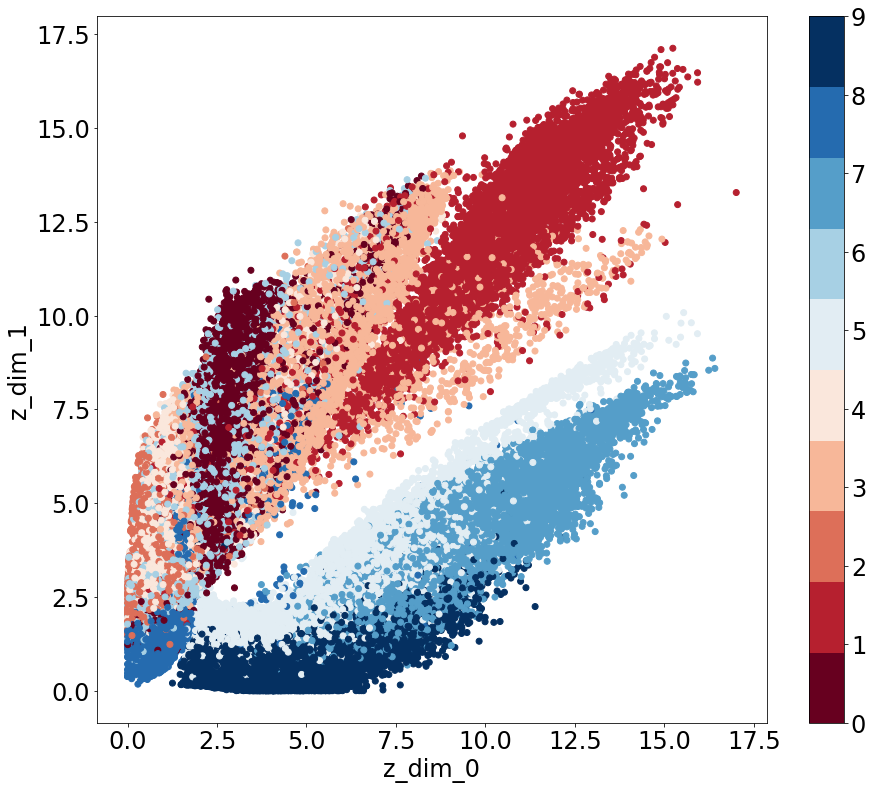

In [7]:
latent_values = ae_encoder.predict(x_train)

font = {'family' : 'sans-serif',
        'size'   : 24}
plt.figure(figsize=(15, 13))
plt.rc('font', **font)
cmap = plt.get_cmap('RdBu', 10)
plt.scatter(latent_values[:, 0], latent_values[:, 1], c=y_train, cmap=cmap)
plt.colorbar()
plt.xlabel("z_dim_0")
plt.ylabel("z_dim_1")
plt.show()

Now we interpolate between two sample data points to see how smoothly the interpolation is going from one sample to another.

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


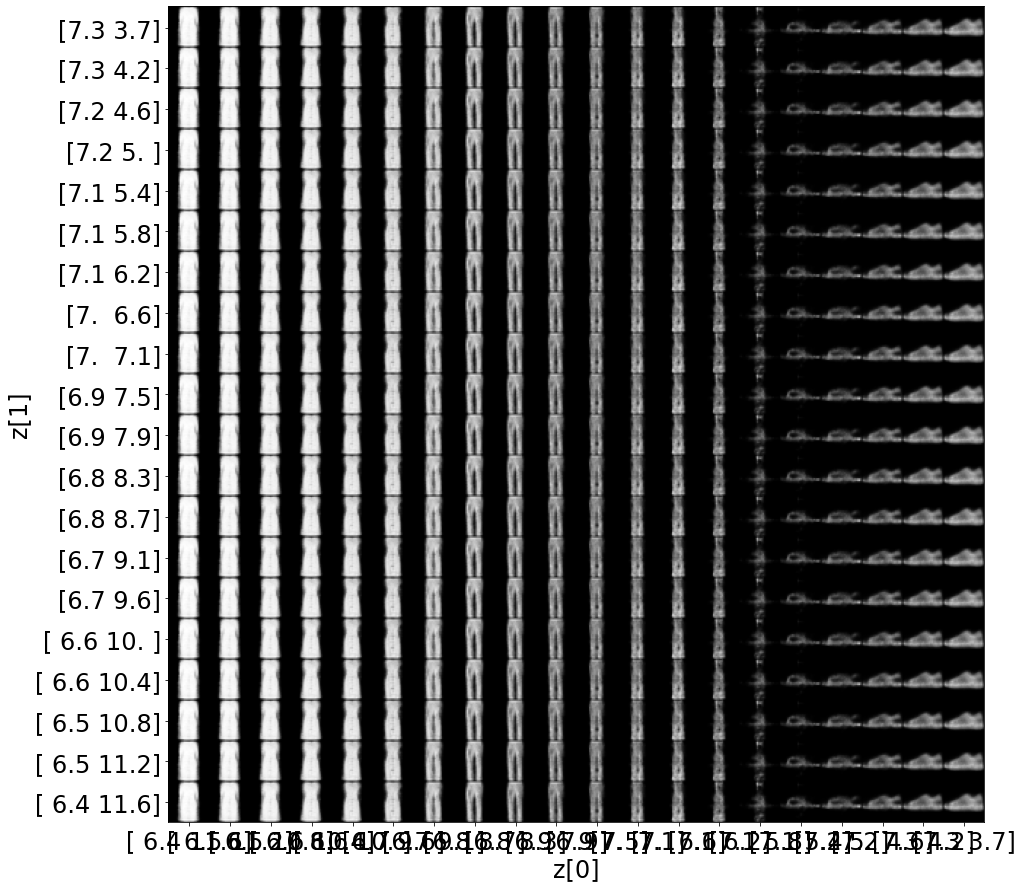

In [8]:
# Interpolation between two random samples

random.seed(29)
random_example_idx = random.randint(0, len(x_train))
random.seed(30000)
random_example_2_idx = random.randint(0, len(x_train))

lin_int_space = np.linspace(latent_values[random_example_2_idx], latent_values[random_example_idx], num=10)

def plot_latent_space(n=20, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(latent_values[random_example_2_idx], latent_values[random_example_idx], n)
    grid_y = np.linspace(latent_values[random_example_2_idx], latent_values[random_example_idx], n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([xi])
            x_decoded = ae_decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space()

# Variational Autoencoder with convolutional layer

The implementation of this VAE is taken from https://keras.io/examples/generative/vae.

In [9]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = (-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))
vae.fit(x_train, epochs=30, batch_size=256)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_2[0][0]                   
____________________________________________________________________________________________

Plot the 2-dimensional latent space of the VAE.

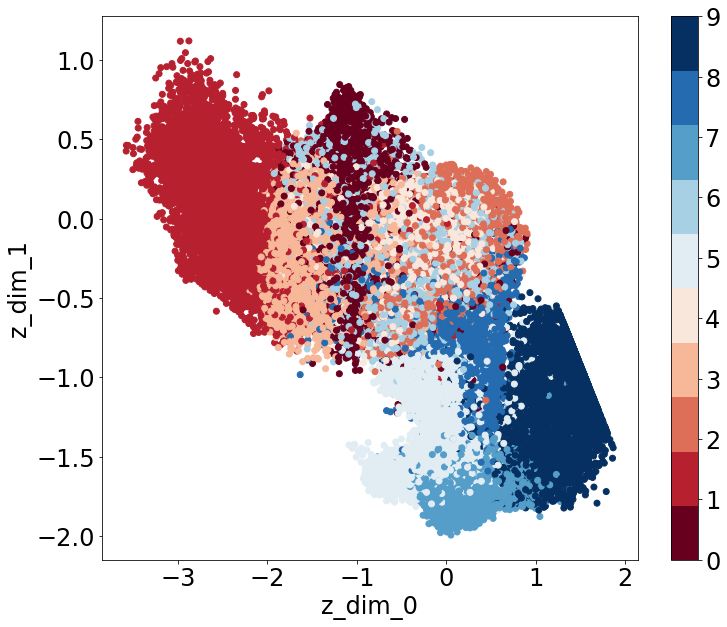

In [10]:
vae_z = vae.encoder.predict(x_train)
cmap = plt.get_cmap('RdBu', 10)
plt.figure(figsize=(12, 10))
plt.scatter(vae_z[0][:, 0], vae_z[0][:, 1], c=y_train, cmap=cmap)
# plt.scatter(vae_z[0][:, 0], vae_z[0][:, 1], c=y_train, cmap=cmap, alpha=1, s=1)
plt.colorbar()
plt.xlabel("z_dim_0")
plt.ylabel("z_dim_1")
plt.show()

Plot the interpolation between the same sample data points as before just for the latent space of the VAE. We see, the transition from the one sample to the other is smoother as in the classical AE case.

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


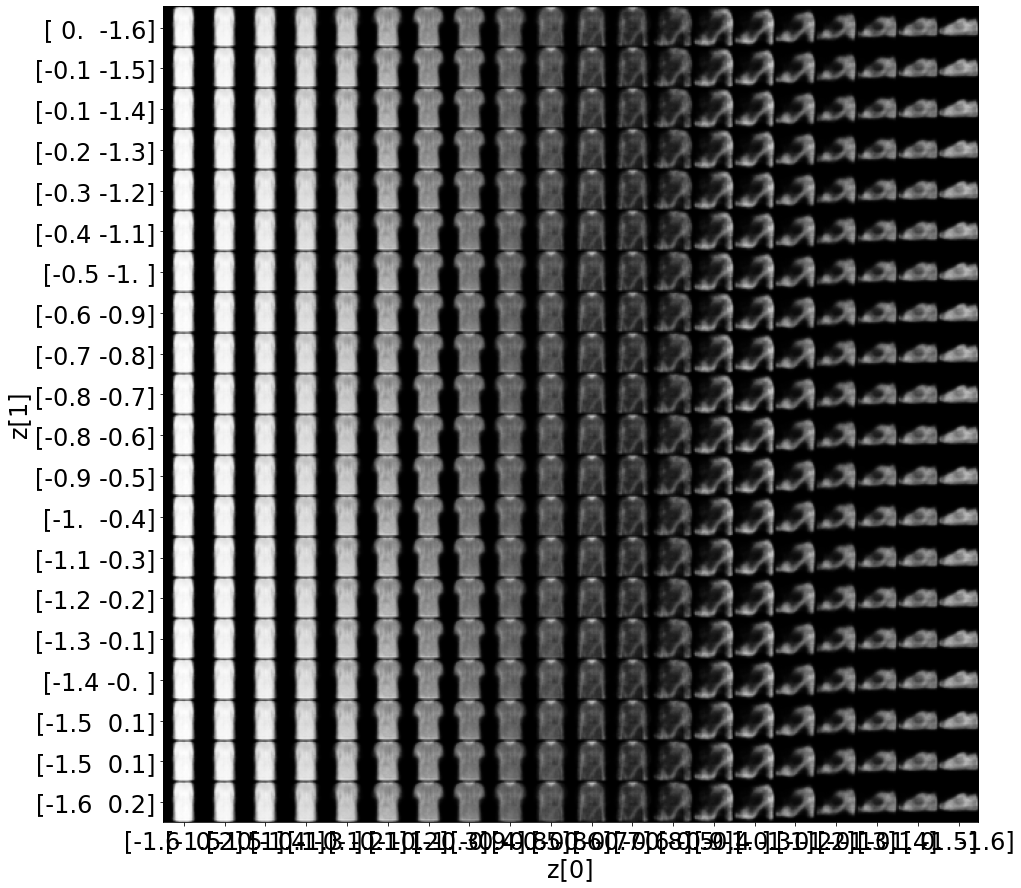

In [11]:
def plot_latent_space(vae, n=20, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(vae_z[0][random_example_2_idx], vae_z[0][random_example_idx], n)
    grid_y = np.linspace(vae_z[0][random_example_2_idx], vae_z[0][random_example_idx], n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([xi])
            x_decoded = vae.decoder.predict(z_sample)
            # x_decoded = ae_decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)